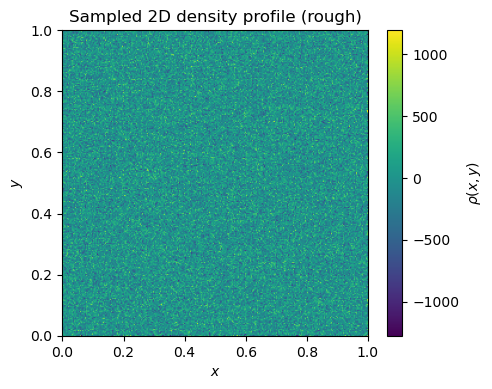

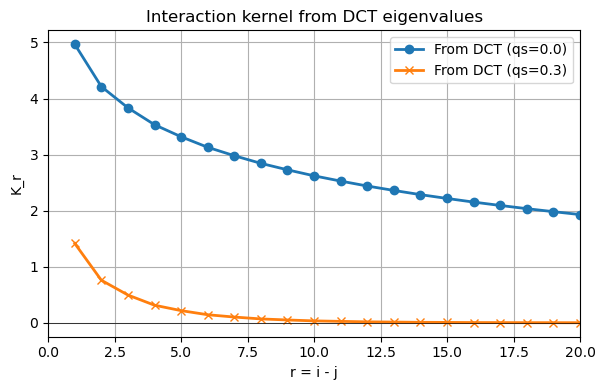

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import math, os, time, copy
import torch.fft as tfft
import pandas as pd
import torch_dct as dct
from numpy import size
from ewaldnn2d import *

torch.random.manual_seed(1234) # for reproducibility

# Global settings
dtype = torch.float64
device = "cpu"
N_batch = 50
N_epochs = 10000
lr = 1e-2 # we will use a LR scheduler, so this is just an initial value
min_delta = 1e-5 # min change in the monitored quantity to qualify as an improvement
patience = 30    # epochs to wait for improvement before stopping training'
pad_mode = "zero" # padding mode for convolution-based routines: either "zero" or "reflect"
N_pow = 1 # number of local features per grid point
N_train = 1500
N_test = 250
N_val = 250

# grid and basis settings
N_x = 256 # number of grid points in x direction
N_y = 256 # number of grid points in y direction
m_x = torch.arange(0, N_x, dtype=dtype, device=device)             # (N_x,)
m_y = torch.arange(0, N_y, dtype=dtype, device=device)             # (N_y,)
abs_val = torch.sqrt(m_x[:, None]**2 + m_y[None, :]**2)  # (M_x, M_y)
x = torch.linspace(0, 1, N_x, dtype=dtype, device=device)            # (N_x,)
y = torch.linspace(0, 1, N_y, dtype=dtype, device=device)            # (N_y,)
DM_x = torch.cos(torch.pi * torch.outer(m_x, x))                  # (M_x, N_x)
DM_y = torch.cos(torch.pi * torch.outer(m_y, y))                  # (M_y, N_y)
DerDM_x = -torch.pi * m_x[:, None] * torch.sin(torch.pi * torch.outer(m_x, x))  # (M_x, N_x) # derivative of design matrix
DerDM_y = -torch.pi * m_y[:, None] * torch.sin(torch.pi * torch.outer(m_y, y))  # (M_y, N_y) # derivative of design matrix

data_regime = "rough" # "smooth" or "rough"
if data_regime == "smooth":
    M_cutoff = 20 # maximum harmonic   
    std_harm = 2.0 / (1.0 + 0.2 * abs_val)**2 * (abs_val <= M_cutoff).double()  # (M_x, M_y)
elif data_regime == "rough":
    std_harm = 2.0 / (1.0 + 0.0 * abs_val)**2 # (M_x, M_y)
else:
    raise ValueError("regime must be 'smooth' or 'rough'")
std_harm[0, 0] = 0.0 # no uniform density offset

# rho, dro_x, dro_y, a = sample_density(std_harm=std_harm, DM_x=DM_x, DerDM_x=DerDM_x, DM_y=DM_y, DerDM_y=DerDM_y)
N_batch = 10
rho_batch, _, _ , a_batch = sample_density_batch(N_batch, std_harm=std_harm, DM_x=DM_x, DerDM_x=DerDM_x, DM_y=DM_y, DerDM_y=DerDM_y) 


rho_np = rho_batch[0, :, :].detach().cpu().numpy()
plt.figure(figsize=(5, 4))
im = plt.imshow(
    rho_np.T,              # transpose so x is horizontal, y vertical
    origin="lower",
    extent=[0, 1, 0, 1],   # x from 0 to 1, y from 0 to 1
    aspect="equal"
)
plt.colorbar(im, label=r"$\rho(x,y)$")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
if data_regime == "rough":
    plt.title("Sampled 2D density profile (rough)")
elif data_regime == "smooth":
    plt.title("Sampled 2D density profile (smooth)")
plt.tight_layout()
plt.show()


# # generate train/test split
# rho_train, d_rho_x_train, d_rho_y_train, a_train = sample_density_batch(N_train, std_harm=std_harm, DM_x=DM_x, DerDM_x=DerDM_x, DM_y=DM_y, DerDM_y=DerDM_y)  # (N_train, N_x, N_y)
# rho_test, d_rho_x_test, d_rho_y_test, a_test = sample_density_batch(N_test, std_harm=std_harm, DM_x=DM_x, DerDM_x=DerDM_x, DM_y=DM_y, DerDM_y=DerDM_y)   # (N_test, N_x, N_y)
# rho_val, d_rho_x_val, d_rho_y_val, a_val = sample_density_batch(N_val, std_harm=std_harm, DM_x=DM_x, DerDM_x=DerDM_x, DM_y=DM_y, DerDM_y=DerDM_y)    # (N_val, N_x, N_y)
# features_train = generate_loc_features_rs(rho_train, N_pow=N_pow)  # (N_train, N_x, N_y, N_feat)
# features_test  = generate_loc_features_rs(rho_test, N_pow=N_pow)   # (N_test, N_x, N_y, N_feat)
# features_val   = generate_loc_features_rs(rho_val, N_pow=N_pow)    # (N_val, N_x, N_y, N_feat)
# # targets_train = E_tot(rho_train)            # (N_train,)
# # targets_test  = E_tot(rho_test)             # (N_test,)
# # targets_val   = E_tot(rho_val)              # (N_val,)

# # Normalize features
# mean_feat, std_feat = compute_normalization_stats(features_train)
# features_train_norm = normalize_features(features_train, mean_feat, std_feat)
# features_test_norm = normalize_features(features_test, mean_feat, std_feat)
# features_val_norm = normalize_features(features_val, mean_feat, std_feat)





# # # interaction kernel parameters
# # kernel_regime = "double_Gaussian" # "single_Gaussian" or "double_Gaussian" 
# # if kernel_regime == "single_Gaussian":
# #     amp_Gaussian = 1.0 # amplitude of Gaussian kernel for interaction energy
# #     sigma_Gaussian = 3.0 # width of Gaussian kernel for interaction energy
# # elif kernel_regime == "double_Gaussian":
# #     amp_Gaussian_1 = -1.0 # amplitude of first Gaussian kernel for interaction energy
# #     sigma_Gaussian_1 = 3.0 # width of first Gaussian kernel for interaction energy
# #     amp_Gaussian_2 = 2.0 # amplitude of second Gaussian kernel for interaction energy
# #     sigma_Gaussian_2 = 1.0 # width of second Gaussian kernel for interaction energy
# # else:
# #     raise ValueError("Here kernel_regime must be 'single_Gaussian' or 'double_Gaussian'")


# # if kernel_regime == "single_Gaussian":
# #     def E_tot(rho: torch.Tensor) -> torch.Tensor:
# #         return amp_Gaussian * E_int_conv(rho, kernel="gaussian", sigma=sigma_Gaussian, pad_mode=pad_mode)
# # elif kernel_regime == "double_Gaussian":
# #     def E_tot(rho: torch.Tensor) -> torch.Tensor:
# #         return (amp_Gaussian_1 * E_int_conv(rho, kernel="gaussian", sigma=sigma_Gaussian_1, pad_mode=pad_mode) +
# #                 amp_Gaussian_2 * E_int_conv(rho, kernel="gaussian", sigma=sigma_Gaussian_2, pad_mode=pad_mode))
    


# # # Normalize targets
# # E_mean = targets_train.mean()
# # E_std = targets_train.std()
# # targets_train_norm = (targets_train - E_mean) / E_std
# # targets_test_norm = (targets_test - E_mean) / E_std
# # targets_val_norm = (targets_val - E_mean) / E_std

# # # Datasets
# # train_dataset = TensorDataset(features_train_norm, targets_train_norm)
# # val_dataset   = TensorDataset(features_val_norm,   targets_val_norm)
# # test_dataset  = TensorDataset(features_test_norm,  targets_test_norm)

# # # Loaders
# # train_loader = DataLoader(train_dataset, batch_size=N_batch, shuffle=True,  drop_last=False)
# # val_loader   = DataLoader(val_dataset,   batch_size=N_batch, shuffle=False, drop_last=False)
# # test_loader  = DataLoader(test_dataset,  batch_size=N_batch, shuffle=False, drop_last=False)


# # R = 10 
# # r_grid = torch.arange(-R, R+1)
# # plt.figure(figsize=(6,4))
# # if kernel_regime == "single_Gaussian":
# #     plt.plot(r_grid, amp_Gaussian * K_gaussian(r_grid, sigma=sigma_Gaussian), 'o-', linewidth=2)
# # elif kernel_regime == "double_Gaussian":
# #     plt.plot(r_grid, amp_Gaussian_1 * K_gaussian(r_grid, sigma=sigma_Gaussian_1) + amp_Gaussian_2 * K_gaussian(r_grid, sigma=sigma_Gaussian_2), 'o-', linewidth=2)
# # plt.axhline(0, color='k', linewidth=0.5)
# # plt.xlabel("r = i - j")
# # plt.ylabel("K_r")
# # plt.title(f"Local kernel")
# # plt.grid(True)
# # plt.tight_layout()
# # plt.show()

